# Capital Evictions
Legal aid for vulnerable population in Washington D.C.

## Table of Contents
1. <a href ='#goal'>Problem Statement</a>
2. <a href='#datasources'>Data Sources</a>
3. <a href='#EDA'>Exploratory Data Analysis</a>
4. <a href='#regression'>Regression</a>
 1. <a href='#single'>Linear Regression</a> 
 2. <a href='#multi'>Multilinear Regression</a>
 3. <a href='#lasso'>Lasso</a>
5. <a href='#findings'>Analysis and Findings</a>
6. <a href='#recs'>Recommendations</a>

In [162]:
# Import libraries and set defaults
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

<a id='goal'></a>
## Problem Statement

This analysis aims to assist a legal clinic that provides representation in housing cases to develop a better understanding of the D.C. population impacted by evictions.  To better serve vulnerable tenants, the clinic is seeking to answer two questions:

1.  Does the presence of PUDs in a block group correlate with an increased eviction rate?
2.  What demographic factors are associated with higher eviction rates?

<a id='datasources'></a>
## Data Sources

### The Eviction Lab 
(https://data-downloads.evictionlab.org/)

A research institution of Princeton University, The Eviction Lab is led by Matthew Desmond with the goal of creating a national resource for tracking evictions and eviction filings.

This project utilizes **2016 evictions data for Washington D.C. block groups**, the smallest geographic unit tracked by the U.S. census.

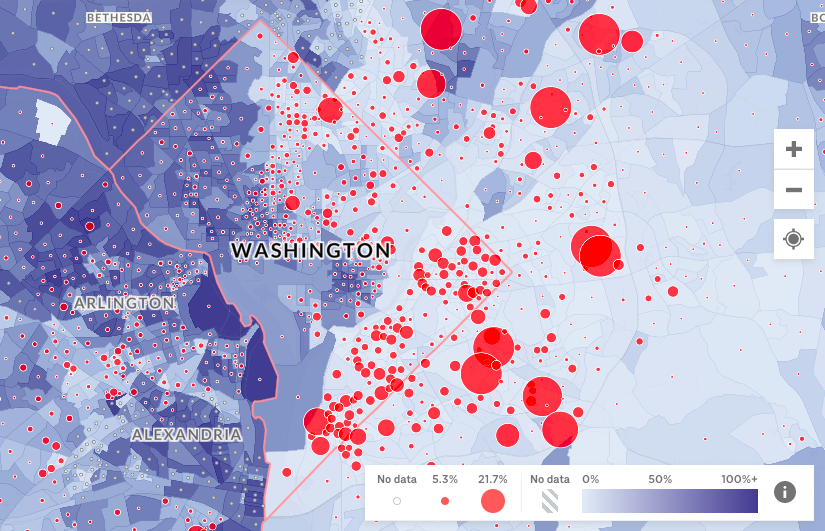

In [211]:
Image("img/evictionlab.png")

*Map from The Eviction Lab showcasing eviction rates in the Washington, D.C area.  Block groups are shaded by the percent white population.*

### Open Data DC 
(https://opendata.dc.gov/datasets/1b3e77aaa6154d1285af639323b0504f_14/data)

A **Planned Unit Development (PUD) refers to a requested exemption from D.C. zoning regulations**.  In exchange for the exemption, the developers must offer a community benefit within the impacted area.  Examples of community benefits include the provision of affordable housing, creation of a park, or contribution to a non-profit. 

This project joins PUD records from Open Data DC with additional research conducted by third-party advocacy group Grassroots D.C. (http://www.grassrootsdc.org/)


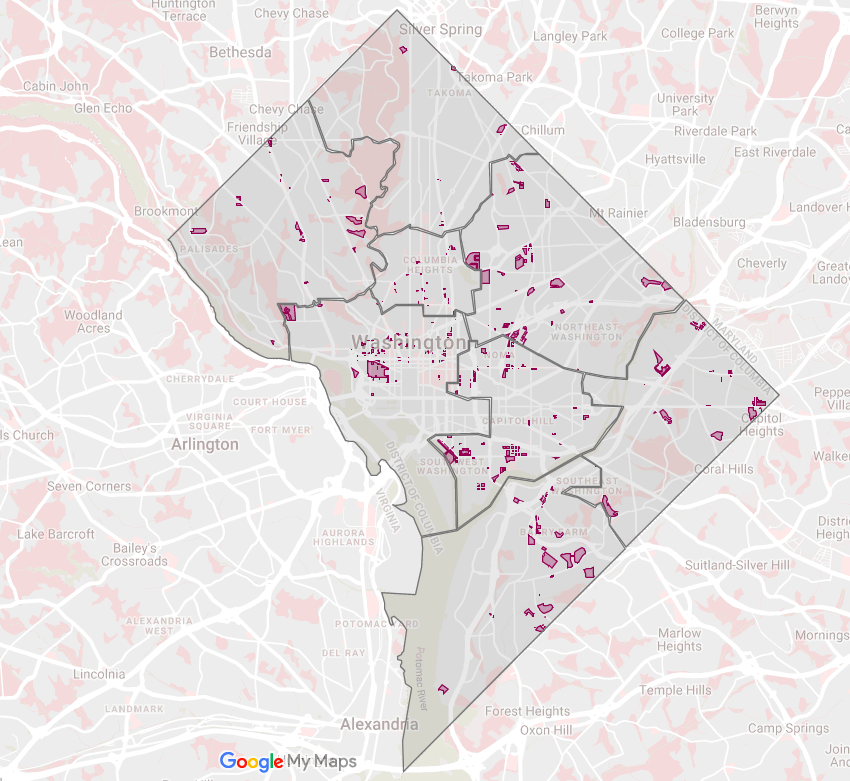

In [163]:
Image("img/puds.png")

*Google My Maps visualization of PUDs within D.C. Wards (https://bit.ly/2DRc011)*

In [127]:
# import data
puds = pd.read_csv('data/final_datasets/master_puds_blocks.csv')

<a id='EDA'></a>
## Exploratory Data Analysis

In [225]:
%run python_files/data_viz

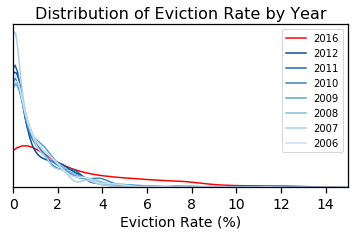

In [226]:
years_dist()

The distribution of eviction rates for 2016 differs significantly from other years in the dataset. However, The Eviction Lab utilizes 2016 as their baseline year for comparison across geographies. Based on their data collection methodology, more records may have been collected for 2016 relative to other years.

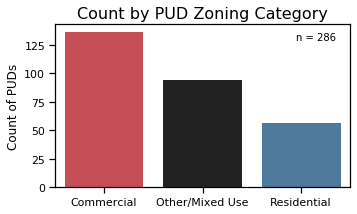

In [227]:
pud_count_by_type(5.3,3)

Majority of PUDs are commercial, followed by mixed use zoning.

In [228]:
%run python_files/data_viz

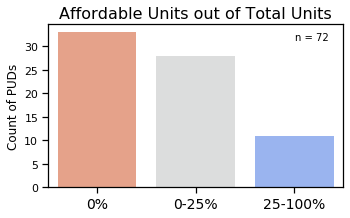

In [229]:
affordable_units_count(5.3,3)

Out of 72 residential PUDs, the majority do not provide affordable units.

<a id='regression'></a>
## Regression

### 1.)  Single Linear Regression - Development

In [232]:
%run python_files/feature_selection_blocks

In [230]:
minipuds = agg_puds(puds)
minipuds[['GEOID','eviction-rate','pud_count','% Affordable Units']].head()

,GEOID,eviction-rate,pud_count,% Affordable Units
0,110010001001,0.53,1,0.0
1,110010001002,0.00,0,0.0
2,110010001003,0.51,0,0.0
3,110010001004,0.38,1,0.0
4,110010002021,0.00,0,0.0


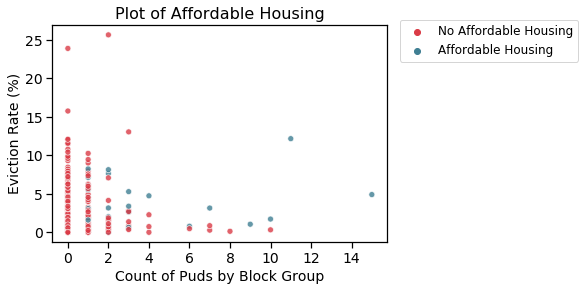

In [233]:
chart_of_affordable_housing(minipuds['pud_count'], minipuds['% Affordable Units'], minipuds['eviction-rate'])

Note that there doesn't appear to be a linear relationship between count of PUDs and eviction rate.  We will confirm this by trying out a linear regression model with the variable 'pud_count' and '% Affordable Units'.

In [220]:
X = minipuds['pud_count']
X = sm.add_constant(X)
model_puds, result_puds = lin_reg(X,minipuds['eviction-rate'])
result_puds.summary()

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          eviction-rate   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6723
Date:                Fri, 06 Dec 2019   Prob (F-statistic):              0.413
Time:                        16:58:44   Log-Likelihood:                -958.67
No. Observations:                 367   AIC:                             1921.
Df Residuals:                     365   BIC:                             1929.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4613      0.187     13.186      0.000       2.094       2.828
pud_count      0.0835      0.102      0.820      0.413      -0.117       0.284
==============================================================================
Omnibus:                      238.751   Durbin-Watson:                   1.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2376.581
Skew:                           2.659   Prob(JB):                         0.00
Kurtosis:                      14.275   Cond. No.                         2.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Poor r-squared indicates that there is unlikely to be a linear relationship between PUD counts / provision of affordable housing through PUDs and eviction rates. 

### 2.)  Multiple Linear Regression - All Features

In [198]:
%run python_files/regression

#### Remove Outliers

In [171]:
puds_to_transform = shrink_data(puds) # limit data to continuous, demographic variables
X, y = drop_outliers(puds_to_transform) # drop rows containing a z-score greater than 3
print('Rows in original dataset:', puds_to_transform.shape[0])
print('Rows in updated dataset:', X.shape[0])

Rows in original dataset: 599
Rows in updated dataset: 489


#### Multicolinearity Check

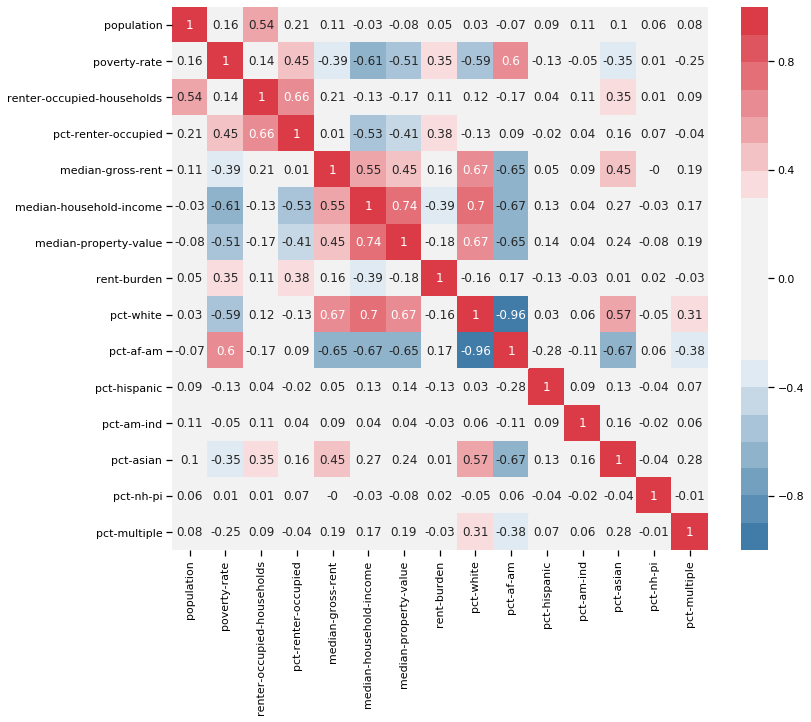

In [172]:
multicolinearity_check(X)

The only variables with a correlation score > 0.75 are 'pct-af-am' and 'pct-white'. Otherwise, multicolinearity is not a significant issue with this dataset.

In [173]:
X = X.drop('pct-af-am',axis=1)

#### Test Train Split

In [174]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=12)

In [175]:
ms = MinMaxScaler()
X_train = ms.fit_transform(X_train.transform(lambda x: np.log(x + 1)))
X_test = ms.transform(X_test.transform(lambda x: np.log(x + 1)))

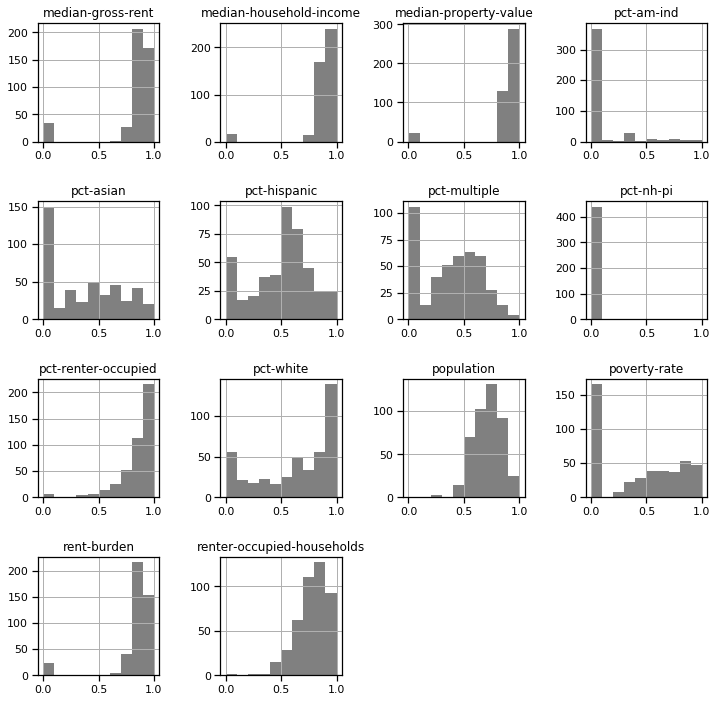

In [176]:
X_labels = [el for el in X.columns]
X, y = transform_arrays_to_df(X_train, y_train, X_labels)
feature_histogram(X)

#### Multiple Linear Regression

In [177]:
# add constants
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [178]:
# multiple linear regression on training data
X_labels = [el for el in X.columns]
model, result = lin_reg(X_train,y_train)
create_summary(result, X_labels)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          eviction-rate   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     45.63
Date:                Fri, 06 Dec 2019   Prob (F-statistic):           1.40e-75
Time:                        16:34:33   Log-Likelihood:                -902.95
No. Observations:                 440   AIC:                             1836.
Df Residuals:                     425   BIC:                             1897.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercept                      1.3853      0.869      1.595      0.112      -0.322       3.093
population                     0.7871      0.898      0.876      0.381      -0.978       2.552
poverty-rate                   1.8174      0.340      5.341      0.000       1.149       2.486
renter-occupied-households     0.6407      1.400      0.458      0.647      -2.111       3.392
pct-renter-occupied            2.6538      1.217      2.181      0.030       0.262       5.046
median-gross-rent             -0.7508      0.595     -1.261      0.208      -1.921       0.420
median-household-income        1.1005      0.585      1.882      0.060      -0.049       2.250
median-property-value          0.1514      0.514      0.294      0.769      -0.860       1.162
rent-burden                    0.1724      0.718      0.240      0.810      -1.238       1.583
pct-white                     -5.0826      0.489    -10.397      0.000      -6.043      -4.122
pct-hispanic                  -0.7772      0.398     -1.955      0.051      -1.559       0.004
pct-am-ind                     0.1321      0.447      0.295      0.768      -0.747       1.011
pct-asian                     -0.3849      0.428     -0.898      0.369      -1.227       0.457
pct-nh-pi                     -0.3920      1.974     -0.199      0.843      -4.273       3.489
pct-multiple                   0.7989      0.382      2.089      0.037       0.047       1.550
==============================================================================
Omnibus:                       40.619   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.679
Skew:                           0.588   Prob(JB):                     7.40e-16
Kurtosis:                       4.555   Cond. No.                         57.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

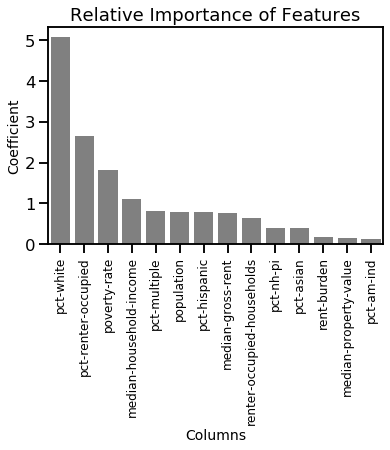

In [179]:
feature_bar_chart(result, X_labels)

Based on coeffients of scaled features, the most important variables for predicting eviction rates at the block group level are “pct-white”, "pct-renter-occupied," “poverty-rate.”

#### Residuals Analysis

In [180]:
y_hat_train = result.predict()

In [199]:
training_table = create_values_table(X, 'pct-white', y, y_hat_train)
training_table.head()

,pct-white,y,y_hat,residual
0,0.739143,0.27,2.795413,-2.525413
1,0.158421,4.03,5.662134,-1.632134
2,0.921963,0.40,0.418661,-0.018661
3,0.036040,8.24,7.117861,1.122139
4,0.911424,1.37,0.168402,1.201598


In [200]:
residual_checks(X_train,y_train)

Tests of normality of residuals:
   - Jarque-Bera: 69.679
   - p-value: 0.0
   - Skew: 0.588
   - Kurtosis: 4.555


Tests of heteroskedasticty of residuals:
   - Lagrange multiplier statistic: 106.201
   - p-value: 0.0
   - f-value: 9.658
   - f p-value: 0.0


Interpretation:
- p-value for J-B test is less than alpha (.05) so reject null hypothesis of normal distribution
- Small positive skew indicates that errors are slightly right skewed (i.e. most of the distribution of residuals at the left)
- Kurtosis greater than 3 indicates that errors have heavier tails than the normal distribution
- p-value for Lagrange is less than alpha (.05) so reject null hypothesis of homoskedasticity of residuals

#### Validation

In [201]:
y_hat_test = result.predict(X_test)

In [202]:
X_test_df = pd.DataFrame(X_test)
X_test_df.drop(0,axis=1, inplace=True)
X_test_df.columns = X_labels
test_table = create_values_table(X_test_df, 'pct-white', y_test, y_hat_test)
test_table.head()

,pct-white,y,y_hat,residual
0,0.048589,4.73,7.049509,-2.319509
1,0.727358,3.28,2.903543,0.376457
2,0.515502,1.74,3.887044,-2.147044
3,0.950605,1.45,0.490920,0.959080
4,0.542166,0.00,1.564721,-1.564721


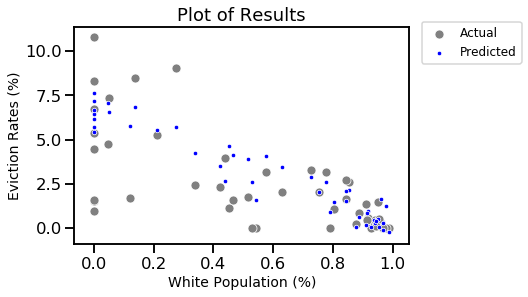

In [204]:
y_vs_y_hat_scatter(test_table['pct-white'], test_table['y'], test_table['y_hat']) 

In [205]:
print('Training MSE:', round(mean_squared_error(y_train, y_hat_train),2))
print('Test MSE:', round(mean_squared_error(y_test, y_hat_test),2))

Training MSE: 3.55
Test MSE: 3.85


#### Cross-Validation

In [206]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

print('CV MSE with  5 folds:', -round(np.mean(cross_val_score(linreg, X_train, y_train, cv=5,  scoring='neg_mean_squared_error')),2))
print('CV MSE with 10 folds:', -round(np.mean(cross_val_score(linreg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')),2))
print('CV MSE with 20 folds:', -round(np.mean(cross_val_score(linreg, X_train, y_train, cv=20, scoring='neg_mean_squared_error')),2))

CV MSE with  5 folds: 3.82
CV MSE with 10 folds: 3.85
CV MSE with 20 folds: 3.83


### 3.) Lasso Regularization

In [207]:
%run python_files/regression

In [208]:
# Define the alpha values to test
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, .5, 1]

# Initialize the dataframe to store coefficients
alpha_df = conduct_search(initialize_search(X_labels, alpha_lasso), X_train, y_train, alpha_lasso)
alpha_df

,MSE,intercept,population,poverty-rate,renter-occupied-households,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,rent-burden,pct-white,pct-hispanic,pct-am-ind,pct-asian,pct-nh-pi,pct-multiple
alpha_1e-15,3.5482,1.3853,0.787097,1.81737,0.640684,2.65379,-0.750837,1.10051,0.151381,0.172402,-5.08262,-0.777175,0.132052,-0.384929,-0.391995,0.798902
alpha_1e-10,3.5482,1.3853,0.787097,1.81737,0.640684,2.65379,-0.750837,1.10051,0.151381,0.172402,-5.08262,-0.777175,0.132052,-0.384929,-0.391995,0.798902
alpha_1e-08,3.5482,1.38531,0.787096,1.81737,0.640684,2.65379,-0.750836,1.10051,0.151381,0.172401,-5.08262,-0.777175,0.132052,-0.384929,-0.391991,0.798902
alpha_1e-05,3.5482,1.38643,0.786257,1.81755,0.640807,2.65298,-0.749996,1.10005,0.151295,0.171927,-5.08253,-0.776869,0.131896,-0.38481,-0.387279,0.798689
alpha_0.0001,3.54821,1.39657,0.778657,1.81909,0.642013,2.64559,-0.742438,1.09594,0.150513,0.167658,-5.08171,-0.774111,0.130496,-0.383759,-0.344825,0.796772
alpha_0.001,3.54894,1.49774,0.709578,1.83395,0.642263,2.57939,-0.665937,1.05692,0.13976,0.124329,-5.07525,-0.747351,0.116047,-0.372219,-0,0.778197
alpha_0.01,3.58228,2.45607,0.145277,1.93648,0.558467,1.85697,-0.0304981,0.695752,0,0,-5.05653,-0.527533,0,-0.243356,-0,0.607305
alpha_0.5,6.52555,3.49398,0,0.396632,0,0,-0,-0,-0,0,-1.58336,-0,-0,-0,0,-0
alpha_1,8.88203,2.6713,0,0,0,0,-0,-0,-0,0,-0,-0,-0,-0,0,-0


In [209]:
alpha_df.loc[alpha_df.MSE == min(alpha_df.MSE)]

,MSE,intercept,population,poverty-rate,renter-occupied-households,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,rent-burden,pct-white,pct-hispanic,pct-am-ind,pct-asian,pct-nh-pi,pct-multiple
alpha_1e-15,3.5482,1.3853,0.787097,1.81737,0.640684,2.65379,-0.750837,1.10051,0.151381,0.172402,-5.08262,-0.777175,0.132052,-0.384929,-0.391995,0.798902


In [210]:
lasso = Lasso(alpha=1e-15, max_iter=1e5)
lasso.fit(X_train, y_train)

y_h_lasso_train = lasso.predict(X_train)
y_h_lasso_test = lasso.predict(X_test)

print('Lasso Training MSE:', round(mean_squared_error(y_train, y_h_lasso_train),2))
print('Lasso Test MSE:', round(mean_squared_error(y_test, y_h_lasso_test),2))

Lasso Training MSE: 3.55
Lasso Test MSE: 3.85


<a id='findings'></a>
## Analysis and Findings

1. Eviction disproportionately impacts people of color
2. Percentage of renter occupied households and poverty-rate also have some predictive power for eviction rate
3. The count of PUDs and the provision of afforable housing have no clear impact on eviction rates 

<a id='recs'></a>
## Recommendations

1. Continue analysis at block group level, accounting for the fact that a PUD may be adjacent to one or more block groups
2. Repeat analysis, taking into account PUD status as of 2016 (year of eviction rate data)
3. Evaluate findings across time series data, including development timeline of PUD
4. Repeat analysis with other development vehicles, such as Tax Increment Financing
5. Synthesize findings with additional research about PUD community impact beyond count of affordable units, such as count of family-sized units, project value, etc.
